Matteo Picciolini

# Esercitazione 2

In [1]:
#matplotlib
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

#numpy
import numpy as np

#fit
from scipy.optimize import curve_fit

#center graphs
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

## Esercizio 02.1
- Compute the following 1D integral via Monte Carlo 
$$I = \int_0^1 \frac{\pi}{2}\cos(\pi x/2) dx = 1$$

1. sampling a uniform distribution in $[0,1]$
2. using importance sampling (i.e. sampling a non-uniform probability in $[0,1]$)

Show a picture of both your estimations of $I$ and their uncertainties with a large number of *throws* $M$ (e.g. $M\ge 10^4$) as a function of the number of blocks, $N$.

### Risoluzione
#### Metodo della media

In generale, per risolvere gli integrali con metodi Monte Carlo, si considera la funzione integranda come prodotto tra una distribuzione di probabilità normalizzata $p(x)$ e una funzione $g(x)$. Estraendo un set $x_i$ di numeri distribuiti secondo $p(x)$, si può mostrare che la quantità $G_N = \sum_{i=1}^N g(x_i)$ è uno stimatore dell'integrale $I=\int_0^1 p(x)g(x)$. Procedendo come nella prima esercitazione, ed eseguendo il *data blocking* si può anche ottenere l'incertezza associata alla stima del valore dell'integrale.

Per questo esercizio ho calcolato l'integrale in due modi diversi, con campionamento uniforme nell'intervallo $[0,1)$ e con il metodo dell'*Importance Sampling*, che permette di estrarre numeri casuali secondo una certa distribuzione di probabilità $p(x)$ diversa da quella uniforme: in questo modo è possibile campionare più intensamente zone del dominio in cui la funzione ha valori significativamente diversi da $0$.

#### Importance Sampling

L'*Importance Sampling* consiste nello scegliere come $p(x)$ una funzione che approssima bene l'integranda, e questo può essere fatto anche se $p(x)$ non è esplicitamente contenuta nella funzione integranda:

$$\int f(x) \, \mbox{d}x = \int \biggl[ \frac{f(x)}{p(x)}\biggr]p(x) \, \mbox{d}x\ , $$ 
con $p(x)$ normalizzata e non negativa sull'intervallo di integrazione.

In linea di principio, se si potesse campionare una distribuzione $p(x)$ uguale all'integranda, il risultato che si otterebbe sarebbe ottenuto con varianza che tendente a $0$; di fatto, utilizzando una $p(x)$ simile all'integranda, è possibile ridurre notevolmente la varianza delle stime dell'integrale a parità di numero di estrazioni.

Di norma una buona scelta per $p(x)$ è, quindi, utilizzare lo sviluppo di McLaurin, ma in questo caso si otterrebbe:

$$ p(x) = 1 - \frac{\pi^2 x^2}{8}, $$

che è una funzione che assume valori negativi nell'intervallo $\left[0,1\right]$, e quindi non può essere utilizzata come distribuzione di probabilità. Si può, quindi, pensare di utilizzare lo sviluppo di McLaurin al terzo ordine o provare a calcolare lo sviluppo di Taylor in $x =1$. In alternativa, visto che $p(x)$ deve, poi,  essere invertita per essere campionata, una buona alternativa a questi conti potrebbe essere una distribuzione con andamento lineare:
$$ p(x) = 2\left(2-x\right),$$
già opportunamente normalizzata.

Per campionare $p(x)$ ho, quindi, calcolato
$$ F(x)=\int_0^x 2\left(2-t\right) \, \mbox{d}t= 2x-2x^2,$$
per ottenere:
$$ y = F^{-1}(x) = 1- \sqrt{1-x}.$$

Utilizzando il metodo del *data blocking* ho simulato $M=10^7$ misure divise in $N=100$ blocchi. Il codice che scrivo utilizza la funzione `blocks_averege` già utilizzata nell'esercitazione 1, che accetta come parametri due puntatori a funzione specifici per questo esercizio che chiamo `characteristic_function_uniform_1` e `characteristic_function_uniform_2` per la simulazione con campionamento uniforme e `characteristic_function_sampling_1` per l'*Importance Sampling*. Queste funzioni sono disponibili nel file `Library_02.cpp`. 

Riporto di seguito i risultati della simulazione.

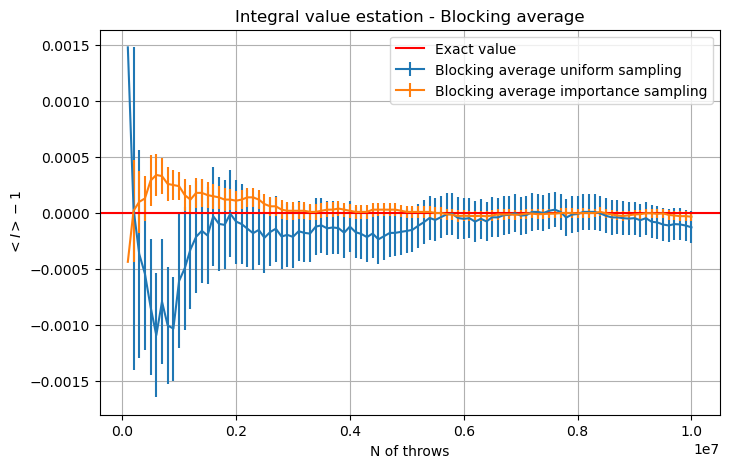

In [2]:
#data acquisition
x_label, progressive_sum, progressive_error = np.loadtxt('../Data/02.1_integral_uniform_sampling.dat',
                                                         usecols = (0, 1, 2), unpack = True)
x_label_samp, progressive_sum_samp, progressive_error_samp = np.loadtxt('../Data/02.1_integral_importance_sampling.dat',
                                                                        usecols = (0,1,2), unpack = True)

#style
plt.figure(figsize = (8,5))
plt.title("Integral value estation - Blocking average")
plt.xlabel('N of throws')
plt.ylabel('$<I>-1$')
plt.grid(True)

#plot
plt.errorbar(x_label,progressive_sum - 1.0, 
             yerr = progressive_error, label = "Blocking average uniform sampling")
plt.errorbar(x_label_samp, progressive_sum_samp - 1.0, 
             yerr = progressive_error_samp, label = "Blocking average importance sampling")
plt.axhline(0, ls = '-',c = 'red', label = "Exact value")

#legend
plt.legend()

plt.show()

Dalla figura è possibile notare come, una volta trovata una distribuzione di probabilità adeguata, il metodo dell'*Importance Sampling* permetta, a parità di tempo di esecuzione del programma o a parità di estrazioni, di ottenere un risultato più preciso ed accurato.  

## Esercizio 02.2
- 3D Random Walks (RW) on a cubic lattice and in the continuum: Repeat many times (e.g. say $10^4$) the simulation of a random walk in 3D always starting at the origin

1. on a cubic lattice with lattice constant $a=1$; at each discrete time the walker makes a forward or backward step of length equal to $a$ in one of the 3 principal directions of the lattice: $x$, $y$ or $z$
2. in the continuum; at each discrete time the walker makes a step of length equal to $a(=1)$ along a **random direction** obtained by sampling **uniformly** the solid angle: $\theta \in [0,\pi]$ and $\phi \in [0,2\pi]$

Show a picture of $\sqrt{\langle |\vec{r}_N|^2 \rangle_{RW}}$ for both RWs, with their statistical uncertainties, as function of the step $i\in [0,10^2]$.

Note that you could try to fit both results with a function like $f(N)=k\sqrt{N}$. Do your results indicate a diffusive behavior?

### Risoluzione

#### Random Walk
Un *Random Walk* (RW) è un processo matematico che descrive una serie di spostamenti successivi in cui ogni spostamento è casuale e indipendente dagli spostamenti precedenti. È un esempio di processo stocastico discreto in cui si effettuano passi casuali in una sequenza di istanti di tempo discreti.

In questo esercizio si è simulato un *Random Walk* discreto all'interno di un reticolo cubico e un *Random Walk* continuo. Si è mostrato, quindi, che l'andamento della radice della distanza del *Random Walker* dall'origine al passo $n$-esimo in funzione del numero di passi compiuti può essere descritto da una curva che segue una legge di diffusione. In particolare, per un *Random Walker* tridimensionale, nel caso asintotico la radice della distanza media dal punto di partenza aumenta proporzionalmente alla radice quadrata del numero di passi.

#### Caso discreto

Per semplificare la simulazione utilizzo un reticolo di passo $a = 1$. Il codice c++ che ho scritto esegue $M=10^4$ simulazioni, ciascuna di $N$ passi ($N = 1,2,\dots,100$). Nel caso discreto il passo può essere eseguito in una qualsiasi delle tre direzioni degli assi cartesiani e, con uguale probabilità in un verso piuttosto che nell'altro. Riporto di seguito il frammento di codice che permette di fare lo step:

```c++
void random_walk_discrete_step(Random &random_generator, std::vector<double> &cartesian_position, double step_lenght){
	int x = random_generator.Rannyu(0,3);
	double var_sign = random_generator.Rannyu(-1,1);
	var_sign = (var_sign >= 0) - (var_sign < 0); //boolean value is 0 when false, 1 when true
	cartesian_position[x] += var_sign * step_lenght;
}
```

Usando la tecnica del *data blocking* ho calcolato la quantità $|\vec{r}_N|^2$ mediandola sui blocchi a $N$ fissato, e poi ne ho estratto la radice quadrata. Ho effettuato il calcolo dell'incertezza di $\langle |\vec{r}_N| \rangle_{RW}$ sempre attraverso il procedimento del *data blocking*, e per ottenere l'incertezza di $\sqrt{\langle |\vec{r}_N|^2 \rangle_{RW}}$ mi è bastato propagare l'errore.

Di seguito mostro il risulato della simulazione.

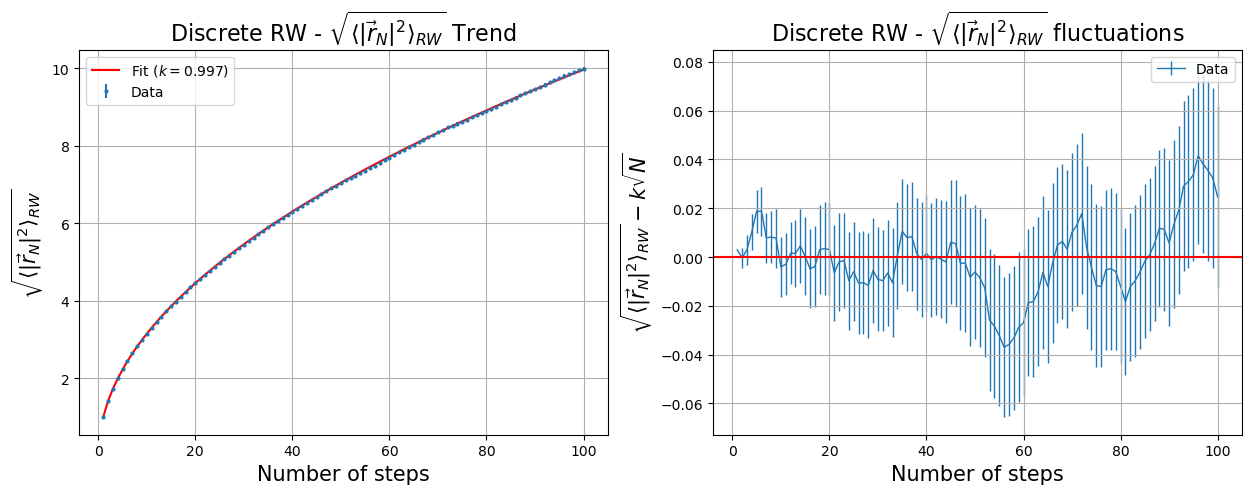

In [3]:
def fit_function(x, a):
    return a * np.sqrt(x)

#data acquisition
step_disc, R_disc, errR_disc = np.loadtxt('../Data/02.2_discrete_random_walk_r_module_square.dat', 
                                          unpack = True, usecols = (0, 1, 2))

#style
fig, axs = plt.subplots(1, 2, figsize = (15, 5))

#plot 1
axs[0].set_title(r'Discrete RW - $\sqrt{\langle |\vec{r}_N|^2 \rangle_{RW}}$ Trend', size = 16)
axs[0].errorbar(step_disc, R_disc, yerr = errR_disc,
                linestyle = " ", marker = "o", 
                label = 'Data', markersize = 2)

#fit
params_discr = curve_fit(fit_function, step_disc, R_disc)
lab ='Fit ($k=$' + str(round(params_discr[0][0], 3)) + ')'
axs[0].plot(step_disc, fit_function(step_disc, params_discr[0]), label = lab, color = "red")
#style plot 1
axs[0].set_xlabel('Number of steps', size = 15)
axs[0].set_ylabel(r'$\sqrt{\langle |\vec{r}_N|^2 \rangle_{RW}}$', size = 15)
axs[0].legend()
axs[0].grid(True)

#plot 2
axs[1].set_title(r'Discrete RW - $\sqrt{\langle |\vec{r}_N|^2 \rangle_{RW}}$ fluctuations', size = 16)
axs[1].errorbar(step_disc, R_disc - fit_function(step_disc, params_discr[0]), yerr = errR_disc,  
            zorder = 1, label = 'Data', lw = 1)
#style plot 2
axs[1].axhline(0, color = 'red')
axs[1].set_xlabel('Number of steps', size = 15)
axs[1].set_ylabel(r'$\sqrt{\langle |\vec{r}_N|^2 \rangle_{RW}} - k\sqrt{N}$', size = 15)
axs[1].legend()
axs[1].grid(True)

I dati ottenuti mostrano come l'errore statistico sia compatibile con l'andamento che ci si aspetta da un processo diffusivo con $k=0.997 \sim 1$. Come è lecito aspettarsi, l'errore associato alla misura aumenta all'aumentare del numero di steps.

#### Caso continuo
Anche per il caso continuo ho mantenuto un passo $a = 1$. Il procedimento che ho seguito è rimasto lo stesso rispetto al caso discreto. L'unica modifica che ho apportato al codice riguarda la possibilità del *random walker* di muoversi in direzioni diverse da quelle dei tre assi cartesiani. In generale, nel caso continuo, il *walker* può muoversi in una qualsiasi combinazione lineare delle tre direzioni, a patto che la norma del vettore spostamento sia unitaria.

Per estrarre valori in modo uniforme sulla superfice della sfera, non basta estrarre uniformemente $\theta \in [0,\pi]$ e $\phi \in [0,2\pi]$ delle coordinate sferiche e utilizzare il cambio di coordinate per ritornare in coordinate cartesiane. Come mostrato dal grafico sottostante, tale procedura porta a sovraccampionare i poli della sfera. Ho scoperto e risolto questo problema leggendo [qui](http://corysimon.github.io/articles/uniformdistn-on-sphere/) e [qui](https://mathworld.wolfram.com/SpherePointPicking.html). In particolare, per risolvere il problema, il secondo link suggerisce di estrarre uniformemente $\theta \in [0,\pi]$ e $u \in [-1, 1]$ e utilizzare il seguente cambio di coordinate:
$$x = \sqrt{(1-u^2)}  \cos{(\theta)},$$
$$y = \sqrt{(1-u^2)} \sin{(\theta)},$$
$$z = u.$$

Per mostrare la differenza, ho estratto $500$ punti in un modo e altri $500$ nell'altro e ho effettuato il seguente grafico con Python.

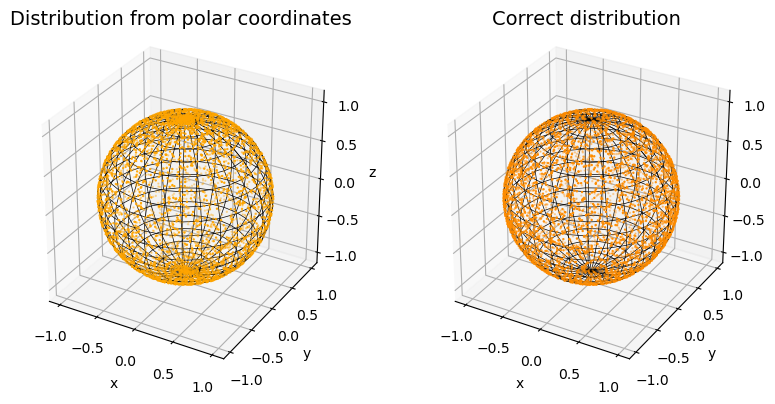

In [4]:
#style
fig = plt.figure(figsize = plt.figaspect(0.5))

#grid
u, v = np.mgrid[0:2 * np.pi:30j, 0:np.pi:20j]
xx = np.cos(u) * np.sin(v)
yy = np.sin(u) * np.sin(v)
zz = np.cos(v)

#data acquisition
n, x, y, z = np.loadtxt('../Data/02.2_distr_non_unif_sphere.dat', unpack = True, usecols = (0, 1, 2, 3))

#plot 1
ax1 = fig.add_subplot(1, 2, 1, projection = '3d')
ax1.set_title('Distribution from polar coordinates', size = 14)
ax1.scatter(x,y,z, s = 0.5, c = "orange")
#plot grid
ax1.plot_wireframe(xx, yy, zz, lw = 0.5, color = "black")
#plot 1 style
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("z")
ax1.set_box_aspect([1,1,1])

#data acquisition
n, x, y, z = np.loadtxt('../Data/02.2_distr_unif_sphere.dat', unpack = True, usecols = (0, 1, 2, 3))

#plot 2
ax2 = fig.add_subplot(1, 2, 2, projection = '3d')
ax2.set_title('Correct distribution', size = 14)
ax2.scatter(x,y,z, s = 0.5, c = "darkorange")
#plot grid
ax2.plot_wireframe(xx, yy, zz, lw = 0.5, color = "black")
#plot 2 style
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("z")
ax2.set_box_aspect([1,1,1])

plt.show()

Da questo grafico si vede in maniera evidente che la distribuzione generata dal cambio di coordinate polari (in arancione chiaro) non è uniforme (la ragione è da ricercarsi nel fatto che l'elemento di area $\mbox{d}\Omega = \sin{\phi}\, \mbox{d}\theta \, \mbox{d}\phi$ è funzione di $\phi$ stessa).

Ho quindi utilizzato il seconda algoritmo per generare punti distribuiti uniformente sulla superficie di una sfera di raggio unitario. Riporto di seguito il frammento di codice che implementa lo step continuo:

```c++
void random_walk_continue_step(Random &random_generator, std::vector<double> &cartesian_position, double step_lenght){
	double theta = random_generator.Rannyu(0, 2.* M_PI);
	double u = random_generator.Rannyu(-1, 1);
	cartesian_position[0] += step_lenght * sqrt(1 - pow(u, 2)) * cos(theta);
	cartesian_position[1] += step_lenght * sqrt(1 - pow(u, 2)) * sin(theta);
	cartesian_position[2] += step_lenght * u;
	
	/*
	double theta = random_generator.Rannyu(0, 2.* M_PI);
	double phi = random_generator.Rannyu(0, M_PI);
	cartesian_position[0] += step_lenght * sin(phi) * cos(theta);
	cartesian_position[1] += step_lenght * sin(phi) * sin(theta);
	cartesian_position[2] += step_lenght * cos(phi);*/
}
```


Ripetendo lo stesso procedimento del caso discreto e utilizzando il metodo del *data blocking* ho ottenuto i risultati seguenti.

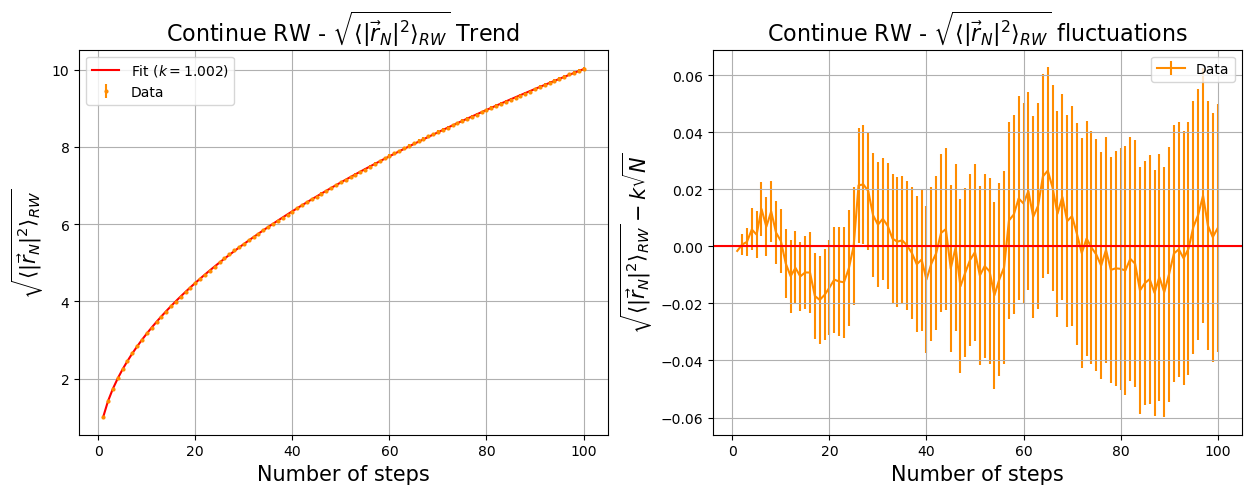

In [5]:
#data acquisition
step_cont, R_cont, errR_cont = np.loadtxt('../Data/02.2_continue_random_walk_r_module_square.dat',
                                          unpack = True, usecols = (0, 1, 2))

#style
fig, axs = plt.subplots(1, 2, figsize = (15, 5))

#plot 1
axs[0].set_title(r'Continue RW - $\sqrt{\langle |\vec{r}_N|^2 \rangle_{RW}}$ Trend', fontsize = 16)
axs[0].errorbar(step_cont, R_cont, yerr = errR_cont, marker = 'o', label = 'Data',
                markersize = 2, color = 'darkorange', linestyle = " ")
#fit
params_cont = curve_fit(fit_function, step_cont, R_cont)
lab = 'Fit ($k=$' + str(round(params_cont[0][0], 3)) + ')'
axs[0].plot(step_cont, fit_function(step_cont, params_cont[0]), label = lab, color = "red")
#style polt 1
axs[0].set_xlabel('Number of steps', size = 15)
axs[0].set_ylabel(r'$\sqrt{\langle |\vec{r}_N|^2 \rangle_{RW}}$', size = 15)
axs[0].legend()
axs[0].grid(True)

#plot 2
axs[1].set_title(r'Continue RW - $\sqrt{\langle |\vec{r}_N|^2 \rangle_{RW}}$ fluctuations', size = 16)
axs[1].errorbar(step_cont, R_cont - fit_function(step_cont, params_cont[0]), yerr = errR_cont,
                zorder = 1, label = 'Data', color = 'darkorange')
#style plot 2
axs[1].axhline(0, color = 'red')
axs[1].set_xlabel('Number of steps', size = 15)
axs[1].set_ylabel(r'$\sqrt{\langle |\vec{r}_N|^2 \rangle_{RW}} - k\sqrt{N}$', size = 15)
axs[1].legend()
axs[1].grid(True)

Come nel caso precedente, i dati ottenuti mostrano come l'errore statistico sia compatibile il valore che ci si aspetta da un processo diffusivo con $k=\sqrt{2D}$ dove $D$ è la costante di diffusione.

Si mostra di seguito uno specchietto che illustra due tipici RW in caso discreto e caso continuo.

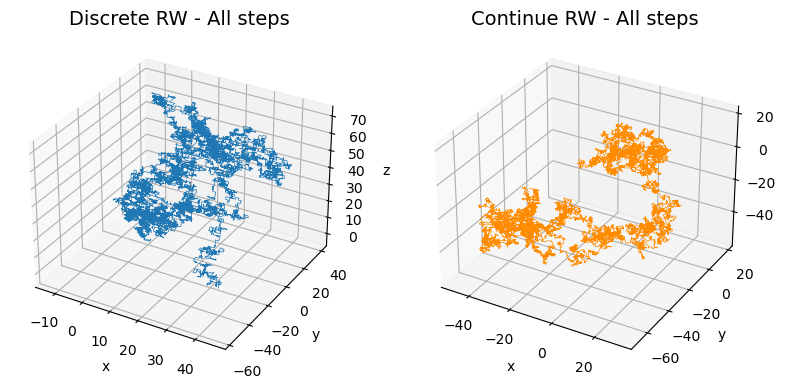

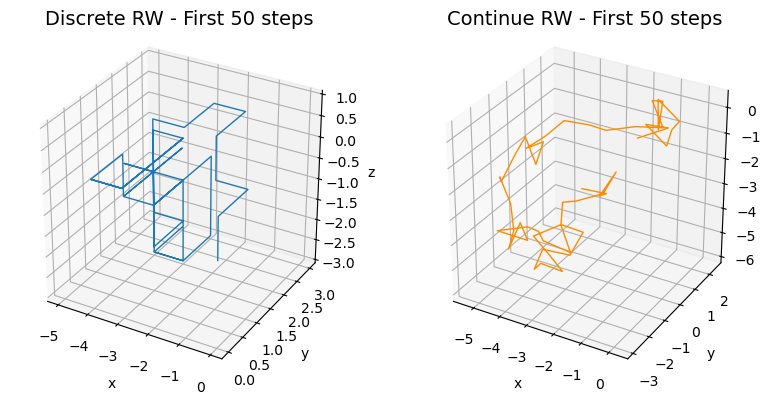

In [6]:
#style
fig = plt.figure(figsize = plt.figaspect(0.5))

#data acquisition
x_d, y_d, z_d = np.loadtxt('../Data/02.2_discrete_random_walk_path.dat', usecols = (0,1,2), unpack = True)
x_c, y_c, z_c = np.loadtxt('../Data/02.2_continue_random_walk_path.dat', usecols = (0,1,2), unpack = True)

#plot 1
ax1 = fig.add_subplot(1, 2, 1, projection = '3d')
ax1.plot3D(x_d, y_d, z_d, lw = 0.5)
#plot 1 style
ax1.set_title('Discrete RW - All steps', size = 14)
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("z")

#plot 2
ax2 = fig.add_subplot(1, 2, 2, projection = '3d')
ax2.plot3D(x_c, y_c, z_c, lw = 0.5, color = "darkorange")
#plot 2 style
ax2.set_title('Continue RW - All steps', size = 14)
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("z")

#style
fig = plt.figure(figsize = plt.figaspect(0.5))

#plot 3
ax3 = fig.add_subplot(1, 2, 1, projection = '3d')
ax3.plot3D(x_d[:50], y_d[:50], z_d[:50], lw = 1)
#plot 3 style
ax3.set_title('Discrete RW - First 50 steps', size = 14)
ax3.set_xlabel("x")
ax3.set_ylabel("y")
ax3.set_zlabel("z")
ax3.set_xlim3d()
ax3.set_zlim3d()
ax3.set_ylim3d()
ax3.set_box_aspect([1,1,1])

#plot 4
ax4 = fig.add_subplot(1, 2, 2, projection = '3d')
ax4.plot3D(x_c[:50], y_c[:50], z_c[:50], lw = 1, color = "darkorange")
#plot 4 style
ax4.set_title('Continue RW - First 50 steps', size = 14)
ax4.set_xlabel("x")
ax4.set_ylabel("y")
ax4.set_zlabel("z")
ax4.set_xlim3d()
ax4.set_zlim3d()
ax4.set_ylim3d()
ax4.set_box_aspect([1,1,1])

plt.show()